# The Solow Model with Human Capital

To investigate the Solow Model with Human Capital, I first set up the Simple Solow Model with Human Capital, find the wage of labor and rent of capital, solve the model for steady-state and simulate growth paths of psychical capital, human capital, production, rent, and wages.

Next, I extend the model to allow for a dependency of physical capital savings on output, thereby reflecting the empirical observation that wealthier nations tend to invest more heavily in physical capital. 

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt

# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# My modules
from modelproj import solow_equations, multi_start, null_clines, find_intersection, simulate_growth_paths

# Predefined options for all plots
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'figure.figsize': (10, 6)})
plt.rcParams.update({'font.size': 10})

## The Solow Model with Human Capital

The Solow Model with Human Capital is given by:
\begin{aligned}
    Y_{t} &= K^{\alpha}_{t}H^{\varphi}_{t}(A_{t}L_{t})^{1-\alpha-\varphi}, \quad 0<\alpha,\varphi<1 \hspace{4em} &(1)\\
    L_{t+1} &= (1+n)L_{t}, \quad L_{0} \text{ given} \hspace{4em} &(2)\\
    A_{t+1} &= (1+g)A_{t}, \quad A_{0}  \text{ given} \hspace{4em} &(3)\\
    K_{t+1} &= s_{K}Y_{t} + (1-\delta)K_{t}, \quad K_{0} \text{ given} \hspace{4em} &(4)\\
    H_{t+1} &= s_{H}Y_{t} + (1-\delta)H_{t}, \quad H_{0} \text{ given} \hspace{4em} &(5)
\end{aligned}

1. The Cobb-Douglas production function represents output, $Y_{t}$, as a function of physical capital, $K_{t}$, human capital, $H_{t}$, technology, $A_{t}$, and labor $L_{t}$. <br>
2. The labor force, $L_{t+1}$, accumulates over time according to population growth, $1+n$. <br>
3. Total factor productivity (TFP, represented as $A_{t}$), accumulates over time according to TFP growth, $1+g$. <br>
4. Physical capital, $K_{t+1}$, accumulates over time through investment in physical capital, $s_{K}Y_{t}$, and depreciation of physical capital, $(1-\delta)K_{t}$. <br>
5. Human capital, $H_{t+1}$, accumulates over time through investment in human capital, $s_{H}Y_{t}$, and depreciation of human capital, $(1-\delta)H_{t}$.

### Deriving Rent and Wages

In the model, all workers possess the same level of human capital; thus, the production function can be expressed as:

\begin{aligned}
    Y_{t} &= K^{\alpha}_{t}h^{\varphi}_{t}A_{t}^{1-\alpha-\varphi}L_{t}^{1-\alpha} &(6)
\end{aligned}

The rent and wages are determined by the marginal product of the production function with regard to to physical capital and labor.

I utilize `SymPy` to derive rent and wages:








In [2]:
import sympy as sm

# Create SymPy symbols for the variables and parameters
Y_t, K_t, h_t, A_t, L_t, alpha, varphi, r_t, w_t = sm.symbols('Y_t, K_t, h_t, A_t, L_t, alpha, varphi, r_t, w_t')

# Set the production function
production_function = K_t**alpha * h_t**varphi * A_t**(1-alpha-varphi) * L_t**(1-alpha)

# Find rent and wages
rent = sm.diff(production_function, K_t)
wages = sm.diff(production_function, L_t)

# Replace the production function with Y_t
rent = rent.subs(production_function, Y_t)
wages = wages.subs(production_function, Y_t)

# For display purposes, I create equations for rent and wages
display_rent = sm.Eq(r_t, rent)
display_wages = sm.Eq(w_t, wages)

# Display rent and wages in SymPy format
display(display_rent, display_wages)


Eq(r_t, Y_t*alpha/K_t)

Eq(w_t, Y_t*(1 - alpha)/L_t)

### Solving the Model for Steady-State

The Solow Model with Human Capital is characterized by two capital accumulation equations, leading to two transition equations and two Solow equations. This model is assessed using technology-adjusted per capita tilde variables that remain constant in steady-state; if, variables are reverted to non-tilde per capita they increase in steady-state.

The model's transition equations are given by:
\begin{aligned}
    \tilde{k}_{t+1} &= \frac{1}{(1+n)(1+g)}(s_{K}\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}-(1-\delta)\tilde{k}_{t}) \hspace{4em} &(7)\\
    \tilde{h}_{t+1} &= \frac{1}{(1+n)(1+g)}(s_{H}\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}-(1-\delta)\tilde{h}_{t}) \hspace{4em} &(8)
\end{aligned}

Thus, the Solow equations are given by:
\begin{aligned}
    \tilde{k}_{t+1}-\tilde{k}_{t} &= \frac{1}{(1+n)(1+g)}(s_{K}\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}-(n+g+\delta+ng)\tilde{k}_{t}) \hspace{4em} &(9)\\
    \tilde{h}_{t+1}-\tilde{h}_{t} &= \frac{1}{(1+n)(1+g)}(s_{H}\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}-(n+g+\delta+ng)\tilde{h}_{t}) \hspace{4em} &(10)
\end{aligned}

In steady state $\tilde{k}_{t+1}=\tilde{k}_{t}=\tilde{k}^{\star}$ and $\tilde{h}_{t+1}=\tilde{h}_{t}=\tilde{h}^{\star}$. 

To solve for $\tilde{k}^*$ and $\tilde{h}^*$ I set $\tilde{k}_{t+1}-\tilde{k}_{t}=0$ and $\tilde{h}_{t+1}=\tilde{h}_{t}=0$ I utilize the algorithm:
1. Set parameter values.

2. Create a function for the Solow equations.
- Set variables to solve for.
- Set 'punishment' for edge-cases (used for later).
- Set Solow equations.

3. Create a function for a Multi-Start Optimizer. I use this function since it converges for all reasonable parameter values.
- Set the smallest residual to infinity.
- Create a list of random samples from a uniform distribution.
- Create a `for loop`.
- Select a random pair of numbers from the uniform distribution and pass it to the optimizer.
- Optimize for a root given the arguments; if the arguments are less or equal to zero, then the function residual is infinity.
- Calculate the residual norm for the optimization.
- If the residual norm is smaller than the current smallest residual, set the residual norm to the smallest residual.
- Return steady-state values.

1. Set parameter values:

In [4]:
# Set parameter values
s_K_val = 0.2
s_H_val = 0.15
n_val = 0.0
g_val = 0.015
delta_val = 0.06
alpha_val = 1/3
varphi_val = 1/3

2. and 3. Solve for the steady-state values:

In [5]:
# Call the Multi-Start function to find the steady state values of physical capital and human capital
steady_state_k, steady_state_h, smallest_residual = multi_start(num_guesses=100,
            bounds = [1e-5, 50],
            fun = solow_equations, 
            args = (s_K_val, s_H_val, n_val, g_val, delta_val, alpha_val, varphi_val), 
            method = 'hybr')

print(f'Muti-Start Solution:\n\
There are {steady_state_k:.3f} units of physical capital, and {steady_state_h:.3f} units of human capital in steady state\n\
The functions residual is {smallest_residual:.3e}')

Muti-Start Solution:
There are 14.222 units of physical capital, and 10.667 units of human capital in steady state
The functions residual is 0.000e+00


The per capita technology-adjusted steady-state production is given by:
\begin{aligned}
    \tilde{y}^{\star} &= (\tilde{k}^{\star})^{\alpha}(\tilde{h}^{\star})^{\varphi}  &(11)
\end{aligned}

Thus:

In [6]:
# Calculate steady state of production
steady_state_y = steady_state_k**alpha_val * steady_state_h**varphi_val

# Print steady-state of production
print(f'There are {steady_state_y:.3f} units of production steady-state')

There are 5.333 units of production steady-state


### Visualizing Steady-State

To find the steady-state levels of physical and human capital graphically, I numerically solve for their respective null clines.
From an analytical perspective, the null clines are given by:
\begin{aligned}
    \tilde{k}_{t} &= \left(\frac{s_K}{n+g+\delta+ng}\right)^{\frac{1}{1-\alpha}}\tilde{h}_{t}^{\frac{\alpha}{1-\alpha}}   \hspace{4em} (12) \\
    \tilde{k}_{t} &= \left(\frac{n+g+\delta+ng}{s_H}\right)^{\frac{1}{1-\alpha}}\tilde{h}_{t}^{\frac{\alpha-\varphi}{1-\alpha}}   \hspace{4em} (13)
\end{aligned}

The null cline for $\tilde{k}_{t}$, (12), indicates the points where the physical capital per technology-adjusted capita $\tilde{k}$  remains constant over time, and the null cline for $\tilde{h}_{t}$, (13), indicates the points where human capital per technology-adjusted capita, $\tilde{h}$, remains constant over time.
The steady-state equilibrium at the intersection of these null clines represents a state where both $\tilde{k}$ and $\tilde{h}$  are constant over time.


To solve for the null clines, I call the function `null_clines` with the specified parameters. 

In [7]:
# Call the function null_clines with the parameter values
k_vec, h_vec_k, h_vec_h = null_clines(s_K_val, s_H_val, g_val, n_val, alpha_val, varphi_val, delta_val)

Due to f(a)f(b)>0, the method failed to find roots for some or all values of k


Next, I plot the null clines.

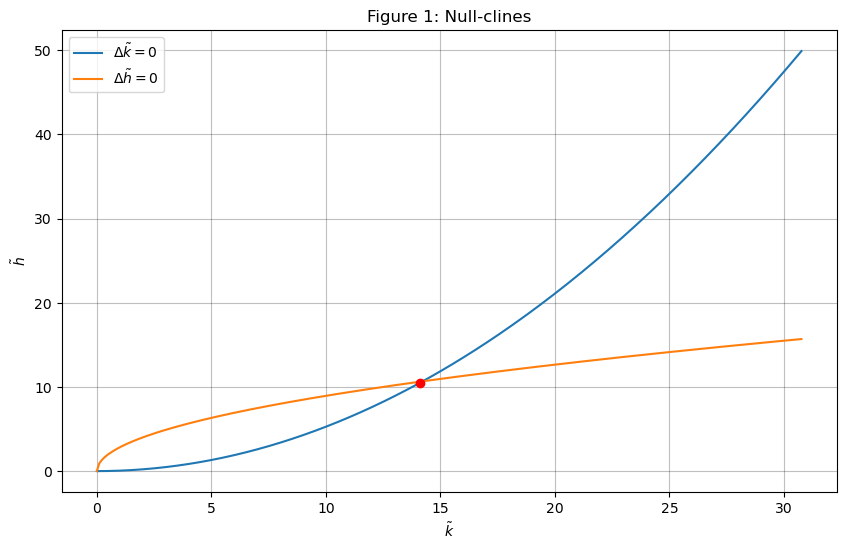

In [8]:
# Create the figure
fig = plt.figure()

# Create the plot 
ax = fig.add_subplot(1,1,1)

# Set null-clines
ax.plot(k_vec, h_vec_k, label= r'$\Delta \tilde{k}=0$')
ax.plot(k_vec, h_vec_h, label= r'$\Delta \tilde{h}=0$')

# Find the intersection dynamically
k_vec_inter, h_vec_k_inter, h_vec_h_inter = find_intersection(k_vec, h_vec_k, h_vec_h)

# Mark the intersection on the plot
ax.plot(k_vec_inter, h_vec_k_inter, 'ro')

# Set title, labels and legend
ax.set_title('Figure 1: Null-clines')
ax.set_xlabel(r'$\tilde{k}$')
ax.set_ylabel(r'$\tilde{h}$')
ax.legend(loc='upper left');

I analyze how an increase in human capital savings changes the equbrilium. 

Due to f(a)f(b)>0, the method failed to find roots for some or all values of k


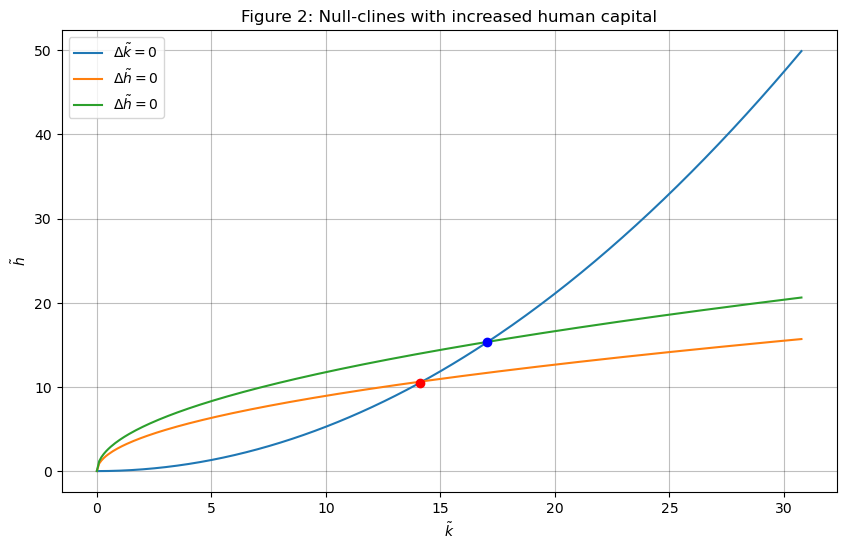

In [9]:
# Call the function null_clines with the increased parameter value for human capital
s_H_k_vec, s_H_h_vec_k, s_H_h_vec_h = null_clines(s_K_val, s_H_val + 0.03, g_val, n_val, alpha_val, varphi_val, delta_val)

# Create the figure and the plot 
fig, ax = plt.subplots()

# Set null-clines
ax.plot(k_vec, h_vec_k, label= r'$\Delta \tilde{k}=0$')
ax.plot(k_vec, h_vec_h, label= r'$\Delta \tilde{h}=0$')
ax.plot(k_vec, s_H_h_vec_h, label= r'$\Delta \tilde{h}=0$')

# Find the intersections dynamically
k_vec_inter, h_vec_k_inter, h_vec_h_inter = find_intersection(k_vec, h_vec_k, h_vec_h)
s_H_k_vec_inter, s_H_h_vec_k_inter, s_H_h_vec_h_inter = find_intersection(s_H_k_vec, s_H_h_vec_k, s_H_h_vec_h)

# Mark the intersection on the plot
ax.plot(k_vec_inter, h_vec_k_inter, 'ro')
ax.plot(s_H_k_vec_inter, s_H_h_vec_h_inter, 'bo')

# Set title, labels and legend
ax.set_title('Figure 2: Null-clines with increased human capital')
ax.set_xlabel(r'$\tilde{k}$')
ax.set_ylabel(r'$\tilde{h}$')
ax.legend(loc='upper left');

Figure 2 shows that an increase in savings in human capital increases both technology-adjusted per capita physical capital and human capital in steady state. The reason is that an increase in human capital savings increases output, and since the savings rate in physical capital is constant, physical capital also increases in steady state.

### Towards Steady State

I simulate growth paths of technology-adjusted per capita physical capital, human capital,  output, rent and wages with the specified parameters. I also simulate a "shock" to savings in human capital by increasing the savings by three percentage points.

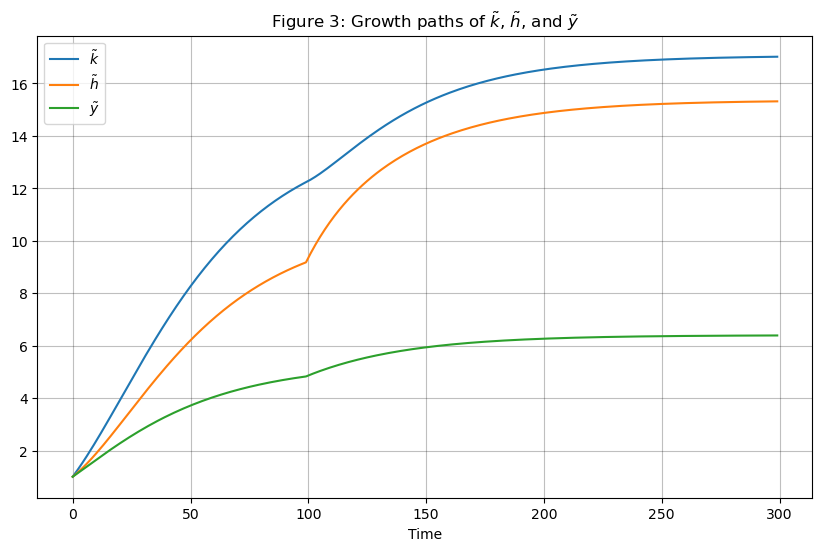

In [10]:
# Call the function simulate_growth_paths with parameters, set shock at t to savings in human capital to XYZ percentage points
K_pc, H_pc, Y_pc = simulate_growth_paths(s_K_val, s_H_val, n_val, g_val, 
                                         delta_val, alpha_val, varphi_val, 
                                         shock_time=100, shock_increase=0.03)

# Plot results
fig, ax = plt.subplots()

# Set growth paths
ax.plot(K_pc, label=r'$\tilde{k}$')
ax.plot(H_pc, label=r'$\tilde{h}$')
ax.plot(Y_pc, label=r'$\tilde{y}$')

# Set title, labels and legend
ax.set_title(r'Figure 3: Growth paths of $\tilde{k}$, $\tilde{h}$, and $\tilde{y}$')
ax.set_xlabel('Time')
ax.legend(loc='upper left');

## Extending the Model with Non-Constant Savings in Human Capital